# Analyzing Fastball Spin Rates Since 2015

Spin rate has been the main pitching variable of discussion in the MLB throughout the past year or so.  It is well known among the baseball community that spin rates have gone way up in recent years, and there is a large amount of evidence to suggest that foreign substances have caused this increase.

In this notebook, I will analyze spin rates since 2015 as this is the most recent year where Statcast data has been available for this variable.  For the purpose of simplicity as different types of pitches have varying average spin rates, the analysis will only pertain to fastballs.  Fastballs are utilized for their speed rather than their spin, though fastballs with a lot of spin tend to be especially effective which would attract foreign substance abuse.  Most pitchers in the game also use the fastball as their main weapon.  Furthermore, I will filter for pitchers who have thrown a sufficient sample size of fastballs in each season (>= 100).

The goal of this analysis is to determine how spin rates have evolved since 2015, which pitchers are most responsible for this evolution, and how changes in spin rate have effected the performance of pitchers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

import glob

import warnings
warnings.filterwarnings("ignore")

Reading in the data:

In [2]:
def combine_files(path):
    
    data_list = []
    for file in glob.glob(path):
        data = pd.read_csv(file)
        data_list.append(data)
        
    combined_data = pd.concat(data_list, axis = 0)
    return combined_data

In [3]:
statcast_file_path = "/Users/Ethan/Desktop/Desktop - Ethan’s MacBook Air/Personal Projects/Baseball/Statcast Data/*"

statcast = combine_files(statcast_file_path)

statcast["game_date"] = pd.to_datetime(statcast["game_date"])
statcast["year"] = statcast["game_date"].dt.year

In [10]:
statcast.sort_values(by = "game_date")

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,year
712567,10233,FF,2015-04-05,94.4,-2.77,5.27,"Walden, Jordan",519203.0,477229.0,NaN,...,3.0,0.0,0.0,3.0,Strategic,Standard,NaN,0.000,0.025,2015
712626,10027,FC,2015-04-05,86.6,-1.06,6.28,"Wainwright, Adam",458085.0,425794.0,NaN,...,3.0,0.0,0.0,3.0,Standard,Standard,NaN,0.000,-0.035,2015
712627,10028,FF,2015-04-05,90.2,-0.91,6.07,"Wainwright, Adam",516770.0,425794.0,single,...,3.0,0.0,0.0,3.0,Standard,Standard,NaN,0.014,0.153,2015
712628,10029,CU,2015-04-05,75.2,-1.08,6.38,"Wainwright, Adam",516770.0,425794.0,NaN,...,3.0,0.0,0.0,3.0,Standard,Standard,NaN,0.000,0.007,2015
712629,10030,FC,2015-04-05,88.3,-1.08,6.15,"Wainwright, Adam",516770.0,425794.0,NaN,...,3.0,0.0,0.0,3.0,Standard,Standard,NaN,0.000,-0.022,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,1374,CH,2021-05-21,84.5,-3.10,6.20,"Frankoff, Seth",453568.0,571676.0,NaN,...,0.0,5.0,5.0,0.0,Standard,Standard,243.0,0.000,0.027,2021
3160,1404,SL,2021-05-21,89.4,-2.90,6.31,"Frankoff, Seth",596115.0,571676.0,double,...,0.0,5.0,5.0,0.0,Infield shift,Strategic,188.0,0.006,0.223,2021
3161,1437,CU,2021-05-21,77.0,-2.82,6.32,"Frankoff, Seth",606132.0,571676.0,home_run,...,0.0,5.0,5.0,0.0,Standard,Standard,34.0,0.094,1.803,2021
3163,1499,FF,2021-05-21,91.2,-2.69,6.40,"Frankoff, Seth",606132.0,571676.0,NaN,...,0.0,3.0,3.0,0.0,Standard,Standard,213.0,0.000,-0.079,2021


We will only analyze four-seam fastball data:

In [4]:
fastballs = statcast[statcast["pitch_type"] == "FF"]

We only care about pitchers who have thrown at least 100 fastballs during the season:

In [5]:
num_pitches = pd.DataFrame(fastballs.groupby(["player_name", "year"]).size()).reset_index().rename(columns = {0: "Num Pitches"})

valid_players = num_pitches[num_pitches["Num Pitches"] >= 100]

spin_rates = fastballs[["player_name", "year", "release_spin_rate"]]
spin_rates = pd.merge(valid_players, spin_rates, on = ["player_name", "year"]).dropna()

## Average Spin Rate Over Time

First, I will provide a simple graph of what the average fastball spin rates have looked like since the beginning of the Statcast era.  This will visualize how spin rates have increased in recent years.

In [72]:
spin_rates_by_year = spin_rates.groupby("year").mean().reset_index()

In [73]:
plot_title = "Average Spin Rate of Fastballs (2015-2021)"
xaxis_title = "Year"
yaxis_title = "Average Spin Rate (RPMs)"

title_x = 0.5

marker_color = 'Green'
paper_bgcolor = "darkred"
plot_bgcolor = "white"

font = dict(family = "Courier New, monospace", size = 11, color = "White")

In [74]:
fig1 = px.bar(spin_rates_by_year, x = 'year', y = 'release_spin_rate', width = 500, height = 600)
fig1.update_xaxes(tickvals = list(range(2015, 2022)))
fig1.update_yaxes(range = [2000, 2400])
fig1.update_traces(marker_color = marker_color)
fig1.update_layout(title = plot_title, title_x = title_x, xaxis_title = xaxis_title, yaxis_title = yaxis_title, font = font, paper_bgcolor = paper_bgcolor, plot_bgcolor = plot_bgcolor)
fig1.show()

The average spin rate has increased every year with the exception of 2016-2017.  Greater increases can be observed since 2018, though the increase hasn't been as significant thus far in 2021.

In [13]:
import chart_studio.plotly as py
import chart_studio

Throughout this notebook, I will save plotly graphs to Chart Studio so they can be embed on Medium.com.

In [14]:
def save_to_chart_studio(fig, file_name):
    
    username = "etsc9287"
    api_key = "NLA3vC0NMfxQxBTQJqh8" #DELETE AFTER SAVING TO GITHUB
    chart_studio.tools.set_credentials_file(username = username, api_key = api_key)
    
    py.plot(fig, filename = file_name, auto_open = True)

In [15]:
save_to_chart_studio(fig1, "spin_rate_by_year")

## Distributions of Spin Rate by Year

In [92]:
plt.rcParams['figure.facecolor'] = 'darkred'
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['font.family'] = 'Courier New, monospace'

In [45]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

2015: Shapiro Statistic = 0.8732467889785767; p-value = 0.0
2016: Shapiro Statistic = 0.962774932384491; p-value = 4.9154820748870175e-34
2017: Shapiro Statistic = 0.9991042017936707; p-value = 0.00998980738222599
2018: Shapiro Statistic = 0.9934394955635071; p-value = 2.1585591116184827e-14
2019: Shapiro Statistic = 0.9974754452705383; p-value = 2.264203970980816e-07
2020: Shapiro Statistic = 0.9452666640281677; p-value = 1.3095834798347578e-39
2021: Shapiro Statistic = 0.973642885684967; p-value = 2.0386060243937804e-29


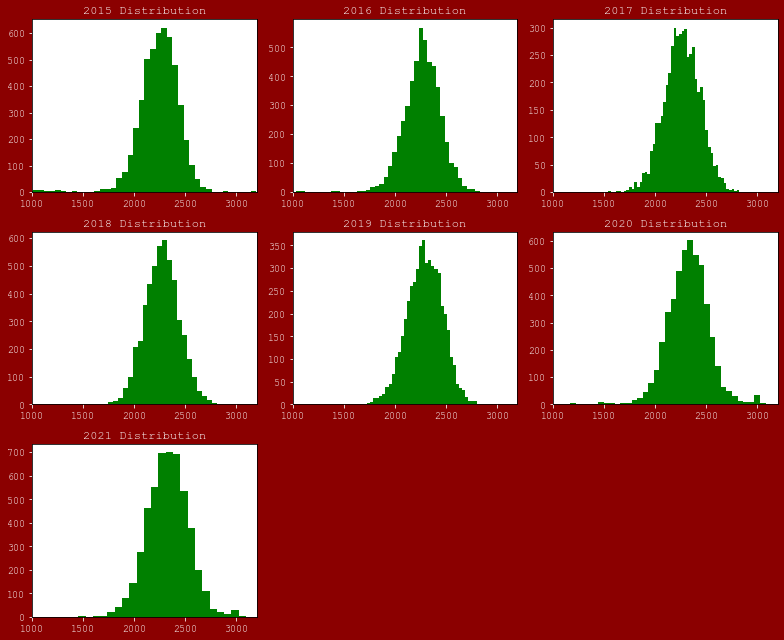

In [68]:
plt.figure(figsize = (11,9))
for i in range(2015, 2022):
    sr_year = spin_rates[spin_rates["year"] == i].sample(5000)["release_spin_rate"]
    plt.subplot(3,3, i - 2014)
    plt.hist(sr_year, bins = 50, color = "green")
    plt.xlim((1000, 3200))
    plt.title(f"{i} Distribution")
    print(f"{i}: Shapiro Statistic = {stats.shapiro(sr_year)[0]}; p-value = {stats.shapiro(sr_year)[1]}")
plt.tight_layout()
plt.show()

In [65]:
sr_2500_2017 = spin_rates[(spin_rates["year"] == 2017) & (spin_rates["release_spin_rate"] >= 2500)]["release_spin_rate"]

sr_2500_2020 = spin_rates[(spin_rates["year"] == 2020) & (spin_rates["release_spin_rate"] >= 2500)]["release_spin_rate"]

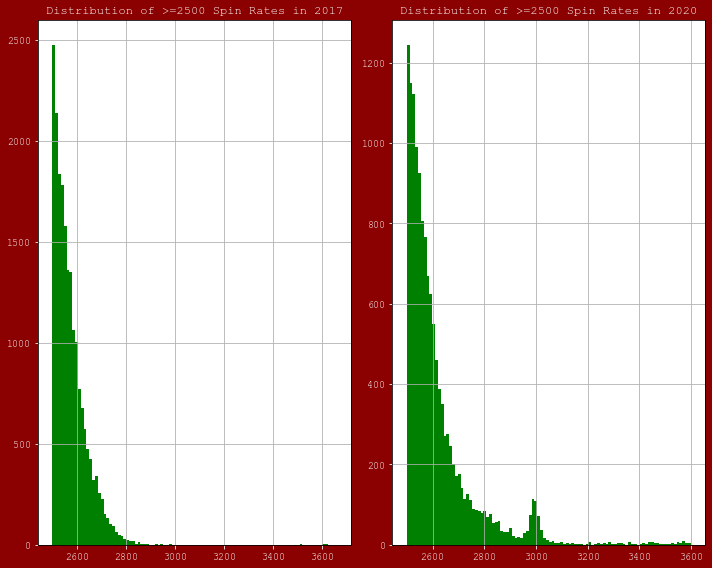

In [66]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
sr_2500_2017.hist(bins = 100, color = "green")
plt.title("Distribution of >=2500 Spin Rates in 2017")
plt.subplot(1,2,2)
sr_2500_2020.hist(bins = 100, color = "green")
plt.title("Distribution of >=2500 Spin Rates in 2020")
plt.tight_layout()
plt.show()

In [75]:
players_2950 = spin_rates[(spin_rates["year"] == 2020) & (spin_rates["release_spin_rate"] >= 2900)]["player_name"].value_counts().reset_index()

In [76]:
len(players_2950)

193

In [77]:
top_players_2950 = players_2950.head(10)

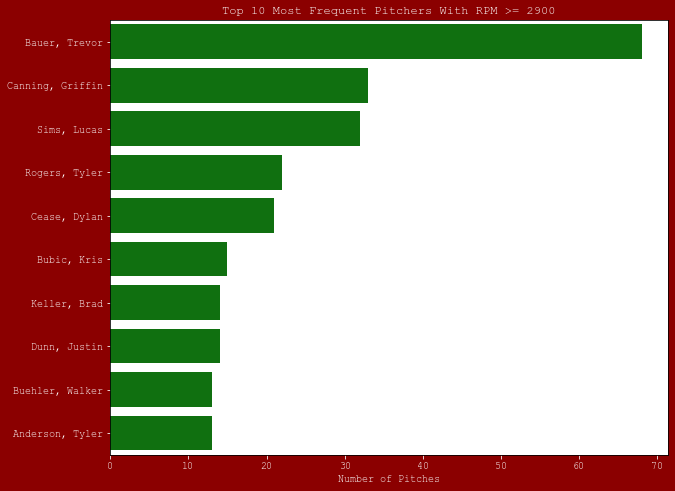

In [79]:
plt.figure(figsize = (10,8))
sns.barplot(data = top_players_2950, y = "index", x = "player_name", color = "green")
plt.xlabel("Number of Pitches")
plt.ylabel(None)
plt.title("Top 10 Most Frequent Pitchers With RPM >= 2900")
plt.show()

## Player Spin Rate Changes Over Time

In [80]:
def get_player_changes(spin_rates, prev_year):
    
    player_year_avgs = spin_rates.groupby(["player_name", "year"]).mean().reset_index()
    
    players = player_year_avgs[player_year_avgs["year"].isin([prev_year, prev_year + 1])][["player_name"]]
    differences = player_year_avgs[player_year_avgs["year"].isin([prev_year, prev_year + 1])].groupby("player_name").diff()

    sr_diffs = pd.concat([players, differences], axis = 1).dropna().rename(columns = {"release_spin_rate": "spin_rate_change"})
    sr_diffs["year"] = f"{str(prev_year)}-{str(prev_year + 1)}"
    
    return sr_diffs.sort_values(by = "spin_rate_change", ascending = False)

In [81]:
player_change_list = []
for year in range(2015, 2021):
    player_change_list.append(get_player_changes(spin_rates, year))
    
player_change_df = pd.concat(player_change_list, axis = 0)

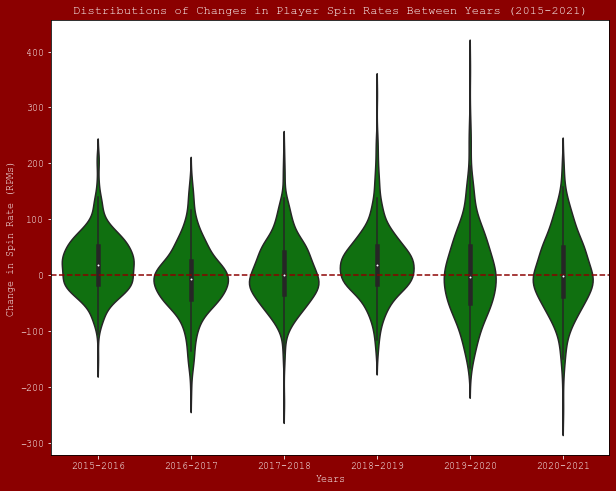

In [87]:
plt.figure(figsize = (10,8))
sns.violinplot(data = player_change_df, x = "year", y = "spin_rate_change", color = "green")
plt.axhline(y = 0, linestyle = "--", color = "darkred")
plt.xlabel("Years")
plt.ylabel("Change in Spin Rate (RPMs)")
plt.title("Distributions of Changes in Player Spin Rates Between Years (2015-2021)")
plt.show()

In [99]:
player_changes_200 = player_change_df[player_change_df["spin_rate_change"] >= 200].sort_values(by = "spin_rate_change", ascending = False)

In [100]:
player_changes_200

,player_name,year,Num Pitches,spin_rate_change
190,"Bauer, Trevor",2019-2020,-881.0,368.586107
368,"Bumgarner, Madison",2018-2019,727.0,323.667856
283,"Boxberger, Brad",2019-2020,-9.0,280.227937
2521,"Sims, Lucas",2018-2019,231.0,249.358144
2471,"Scott, Tanner",2019-2020,-52.0,245.016760
1000,"Ginkel, Kevin",2019-2020,-11.0,242.688343
1005,"Giolito, Lucas",2018-2019,376.0,233.972615
1660,"Mahle, Tyler",2019-2020,-753.0,227.361185
2540,"Smith, Burch",2018-2019,-604.0,226.411230
539,"Cole, Gerrit",2017-2018,198.0,220.911682


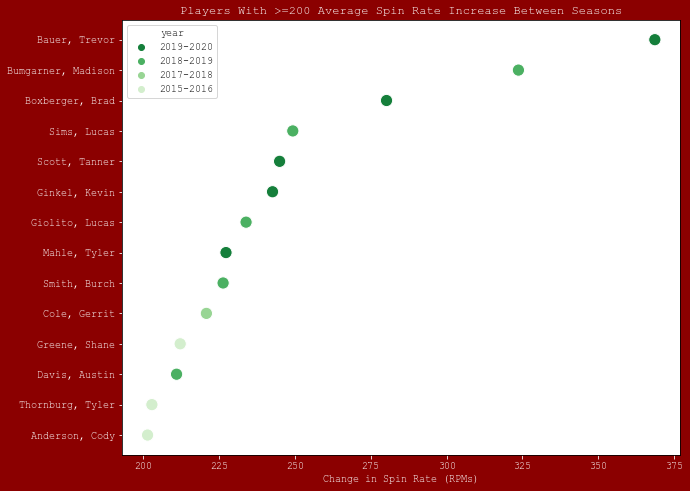

In [104]:
plt.figure(figsize = (10,8))
sns.scatterplot(data = player_changes_200, y = "player_name", x = "spin_rate_change", hue = "year", s = 150, palette = "Greens_r")
plt.xlabel("Change in Spin Rate (RPMs)")
plt.ylabel(None)
plt.title("Players With >=200 Average Spin Rate Increase Between Seasons")
plt.show()

## Modeling: The Effect of Spin Rate Change on ERA Change

In [105]:
year_stats = pd.read_csv("pitcher_split_stats_historical1.csv")

In [106]:
year_stats = year_stats[year_stats["Split"] == "All Splits"][["Player", "Year", "ERA"]]

year_stats["ERA"] = year_stats["ERA"].astype(float)

In [107]:
year_stats["Player"] = year_stats["Player"].str.split()

In [108]:
year_stats["player_name"] = year_stats["Player"].str[-1] + ", " + year_stats["Player"].str[0]

long_name_dict = {"Jr., Lance": "McCullers Jr., Lance", "Leon, Daniel": "Ponce de Leon, Daniel", 
                  "Gonzalez, Chi": "González, Chi Chi", "Jr., Duane": "Underwood Jr., Duane"}

year_stats["player_name"] = year_stats["player_name"].map(long_name_dict).fillna(year_stats["player_name"])

year_stats = year_stats.drop(columns = "Player")

In [109]:
def get_era_changes(year_stats, prev_year):
    
    players = year_stats[year_stats["Year"].isin([prev_year, prev_year + 1])][["player_name"]]
    differences = year_stats[year_stats["Year"].isin([prev_year, prev_year + 1])].groupby("player_name").diff(periods = -1)

    era_diffs = pd.concat([players, differences], axis = 1).dropna().rename(columns = {"ERA": "era_change"})
    era_diffs["year"] = f"{str(prev_year)}-{str(prev_year + 1)}"
    
    return era_diffs.sort_values(by = "era_change", ascending = False).drop(columns = "Year")

In [110]:
era_change_list = []
for year in range(2015, 2021):
    era_change_list.append(get_era_changes(year_stats, year))
    
era_change_df = pd.concat(era_change_list, axis = 0)

In [111]:
model_df = pd.merge(player_change_df, era_change_df, on = ["player_name", "year"])

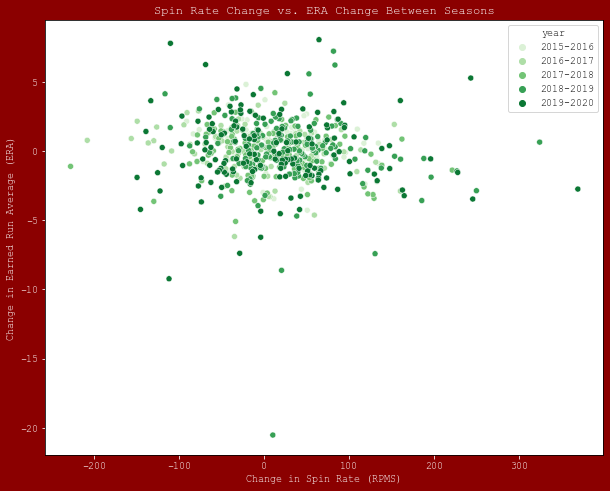

In [120]:
plt.figure(figsize = (10,8))
sns.scatterplot(data = model_df, x = "spin_rate_change", y = "era_change", color = "green", hue = "year", palette = "Greens")
plt.title("Spin Rate Change vs. ERA Change Between Seasons")
plt.xlabel("Change in Spin Rate (RPMS)")
plt.ylabel("Change in Earned Run Average (ERA)")
plt.show()

In [122]:
x_val = pd.get_dummies(model_df[["spin_rate_change", "year"]])
y_val = model_df["era_change"]

x_val = sm.add_constant(x_val)

model = sm.OLS(y_val, x_val)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             era_change   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.113
Date:                Tue, 25 May 2021   Prob (F-statistic):             0.0622
Time:                        15:38:30   Log-Likelihood:                -1359.8
No. Observations:                 630   AIC:                             2732.
Df Residuals:                     624   BIC:                             2758.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0562      0.073  